# Dog Breed Classifier

Udacity Machine Learning Engineer Nanodegree, 2020

## Project overview

This project aims to create Dog Breed Classifier as a capstone project of Udacity Machine Learning Engineer Nanodegree.

The classifier should be able to determine a dog’s breed on a user-provided image. If a user provides an image of a human instead of a dog, the classifier should infer the dog breed that is most resembling.

The problem of detecting whether or not an object is present on the given image could be efficiently solved by using convolutional neural networks (CNNs). They are architectured to extract a set of different features (edges, shapes, colors etc.) from the images and then to make a classification based on these features. 

Examples of state-of-art CNNs are ​[VGG](https://arxiv.org/pdf/1409.1556.pdf),​ [I​nception](http://arxiv.org/abs/1512.00567) ​or [​ResNet](https://arxiv.org/pdf/1512.03385.pdf) to name a few. These CNNs were trained on the [I​mageNet](http://image-net.org/), ​a massive dataset of 10 million images in 1000 categories, including those of dogs. The ability of these networks to extract various features out of an image could be used as a base for dog breed classifier.

## Problem statement

The model should be able to infer the breed of a dog from a user-provided image with at least 80% accuracy. For the fun part, if it is human on the image, the model should infer the dog breed which is most resembling. In case if neither human or dog is depicted on the image, the model should indicate an error.

Assigning breed to dogs from images exceptionally challenging, because even a human would have trouble distinguishing between a [Brittany](https://www.google.com/search?q=Brittany+dog+breed&tbm=isch) and a [Welsh Springer Spaniel](https://www.google.com/search?q=Welsh+Springer+Spaniel+dog+breed&tbm=isch), or a [Curly-Coated Retriever](https://www.google.com/search?q=Curly-Coated+Retriever+dog+breed&tbm=isch) and an [American Water Spaniel](https://www.google.com/search?q=American+Water+Spaniel+dog+breed&tbm=isch). Likewise, labradors come in [yellow](https://www.google.com/search?q=yellow+labrador+dog+breed&tbm=isch), [chocolate](https://www.google.com/search?q=chocolate+labrador+dog+breed&tbm=isch), and [black](https://www.google.com/search?q=black+labrador+dog+breed&tbm=isch).

Given that, the model should be extremely strong in extracting specific features out of the pictures of dogs. It seems reasonable to use transfer learning techniques, leveraging feature-extracting abilities of a pretrained network (e.g. VGG16).

Given that, the model should be extremely strong in extracting specific features out of the pictures of dogs. It seems reasonable to use transfer learning techniques, leveraging feature-extracting abilities of a pretrained network (e.g. VGG16).

In order to solve the problem, the following steps supposed to be made:

1. Create a VGG16-like model and train it from scratch as a benchmark for inferring dog breeds.

2. Create a model using VGG16-based transfer learning and obtain at least 80% accuracy in inferring dog breeds.

3. Create a dog detector using the pre-trained VGG16 model (unmodified).

4. Create a human detector using Viola-Jones Haar cascade classifier or CNN-based face detector (depending on which one is more accurate).

5. Combine all 3 detectors (dog, human, breed) into a single algorithm according to project goals.


## Metric

The accuracy will be used as a metric for evaluation of dog breed classifier model.

Accuracy will be calculated as a ratio of correctly detected dog breeds relative to all processed images.

\begin{equation}
Accuracy = \frac{Number\ of\ correct\ predictions}{Total\ number\ of\ predictions}
\end{equation}

## Environment setup

In [0]:
# Load all necessary libraries and check if GPU is avaliable

from glob import glob
import numpy as np
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models

from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

import matplotlib.pyplot as plt
%matplotlib inline

use_cuda = torch.cuda.is_available()

!nvidia-smi

Fri Jan 31 13:46:52 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.44       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P0    25W / 250W |     10MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

## Data exploration

Two datasets provided by Udacity will be used in this project:

1. Dog images dataset
2. Human imges dataset

The datasets would be downloaded from the Udacity S3 bucket.

In [0]:
# Create data directory
!mkdir data

# Download and extract dog images
!wget -q --show-progress https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
!unzip -q dogImages.zip -d data
!mv data/dogImages data/dog_images

# Download and extract human images
!wget -q --show-progress https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/lfw.zip
!unzip -q lfw.zip -d data
!mv data/lfw data/human_images

dogImages.zip       100%[===================>]   1.05G  21.2MB/s    in 52s     
lfw.zip             100%[===================>] 187.62M  21.4MB/s    in 9.7s    


### Data structure

First of all, let's explore directory structure of provided datasets using linux `tree` command.

If it is not installed, let's intall it.

> Note: this step is supposed to work only in Debian-based Linux environment.

In [0]:
# Install the tree command
!apt-get -qq install -y tree

Selecting previously unselected package tree.
(Reading database ... 145674 files and directories currently installed.)
Preparing to unpack .../tree_1.7.0-5_amd64.deb ...
Unpacking tree (1.7.0-5) ...
Setting up tree (1.7.0-5) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...


In [0]:
# Print the structure of the human_images directory
!tree data/human_images | head

data/human_images
├── Aaron_Eckhart
│   └── Aaron_Eckhart_0001.jpg
├── Aaron_Guiel
│   └── Aaron_Guiel_0001.jpg
├── Aaron_Patterson
│   └── Aaron_Patterson_0001.jpg
├── Aaron_Peirsol
│   ├── Aaron_Peirsol_0001.jpg
│   ├── Aaron_Peirsol_0002.jpg


In [0]:
# Print the structure of the dog_images directory
!tree data/dog_images | head

data/dog_images
├── test
│   ├── 001.Affenpinscher
│   │   ├── Affenpinscher_00003.jpg
│   │   ├── Affenpinscher_00023.jpg
│   │   ├── Affenpinscher_00036.jpg
│   │   ├── Affenpinscher_00047.jpg
│   │   ├── Affenpinscher_00048.jpg
│   │   ├── Affenpinscher_00058.jpg
│   │   ├── Affenpinscher_00071.jpg


There is around of `13 000` of human images and around of `8 000` dog images.

Dog images are already split in `train`, `valid` and `test` datasets in proportion `80%/10%/10%` respectively.


In [0]:
# List dog_images directory
!ls data/dog_images

test  train  valid


In [0]:
human_files = np.array(glob("data/human_images/*/*"))
dog_files = np.array(glob("data/dog_images/*/*/*"))

print('Human images .. {}'.format(len(human_files)))
print('Dog images .... {}'.format(len(dog_files)))
print(' train ........ {}'.format(len([f for f in dog_files if f.split('/')[2] == 'train'])))
print(' valid ........ {}'.format(len([f for f in dog_files if f.split('/')[2] == 'valid'])))
print(' test ......... {}'.format(len([f for f in dog_files if f.split('/')[2] == 'test'])))

### Images visualization

All provided images are color RGB images.

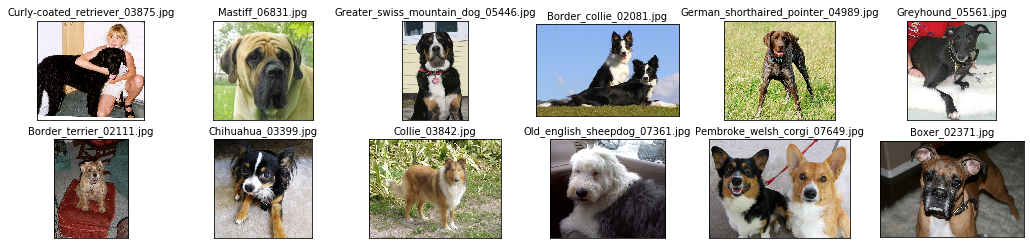

In [0]:
# Plot some of the dog images
np.random.seed(0)
fig = plt.figure(figsize=(18, 4))
i = 0
for idx in np.random.randint(0, len(dog_files), size=12):
  i+=1
  ax = fig.add_subplot(2, 12/2, i, xticks=[], yticks=[])
  plt.imshow(Image.open(dog_files[idx]))
  ax.set_title(dog_files[idx].split('/')[4], fontsize=10)

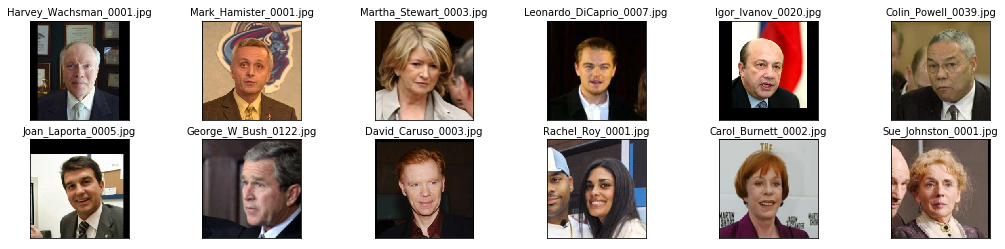

In [0]:
# Plot some of the human images
np.random.seed(0)
fig = plt.figure(figsize=(18, 4))
i = 0
for idx in np.random.randint(0, len(human_files), size=12):
  i+=1
  ax = fig.add_subplot(2, 12/2, i, xticks=[], yticks=[])
  plt.imshow(Image.open(human_files[idx]))
  ax.set_title(human_files[idx].split('/')[3], fontsize=10)

### Images size

The human images come in one size: `250x250px`, while the dog images come in various sizes. 

The majority of dog images has the size within `1000px` in width and height.

In [0]:
# Get the shape of all images

human_files_shape = [cv2.imread(img_path).shape[:2] for img_path in human_files]
dog_files_shape = [cv2.imread(img_path).shape[:2] for img_path in dog_files]

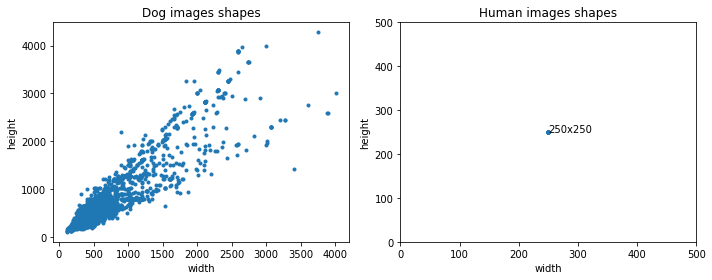

In [0]:
# Plot image shapes

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

ax1.set_title('Dog images shapes')
ax1.scatter([shape[0] for shape in dog_files_shape], [shape[1] for shape in dog_files_shape], marker='.')
ax1.set_xlabel('width')
ax1.set_ylabel('height')

ax2.set_title('Human images shapes')
ax2.scatter([shape[0] for shape in human_files_shape], [shape[1] for shape in human_files_shape], marker='.')
ax2.set_xlim([0,500])
ax2.set_ylim([0,500])
ax2.set_xlabel('width')
ax2.set_ylabel('height')
ax2.annotate('{}x{}'.format(*human_files_shape[0]), xy=human_files_shape[0])

fig.tight_layout()

### Image distribution by breed

Totally `133` breed classes are provided in the dataset. 

Each bread has at least `26` images, but the number of images provided for each class is not balanced.

In order to mitigate this issue, some kind of data augmentation could be made during loading data for training, like image flipping.

Total breeds: 133


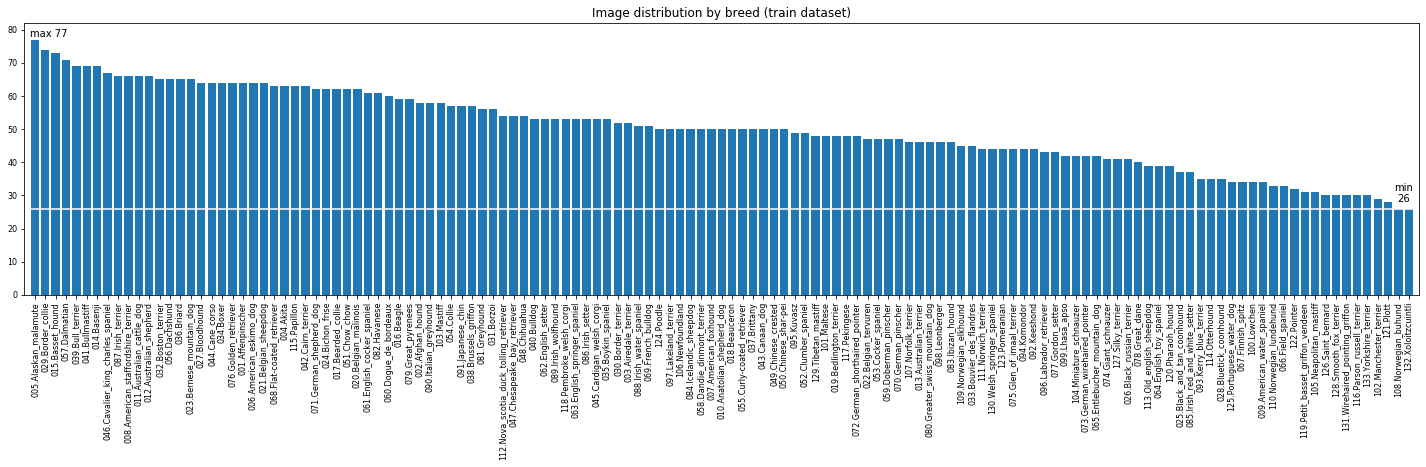

In [0]:
# Plot distribution of images by breeds

train_labels = [f.split('/')[3] for f in dog_files if f.split('/')[2] == 'train']

labels, img_count = np.unique(train_labels, return_counts=True)
sorted_indices = np.argsort(-img_count)

print('Total breeds:', len(labels))

plt.figure(figsize=(25, 5))
y_pos = np.arange(1, len(labels)+1)
plt.bar(y_pos, img_count[sorted_indices], align='center')
plt.xticks(y_pos, labels[sorted_indices], rotation=90)
plt.tick_params(labelsize=8)
plt.xlim([0, y_pos.size+1])

# max label
max_count = np.max(img_count)
plt.text(0.5, max_count+0.9, 'max {}'.format(max_count))
plt.ylim([0, max_count+5])

# min label & line
min_count = np.min(img_count)
plt.text(labels.size-0.5, min_count+2, 'min\n{}'.format(min_count), horizontalalignment='center')
plt.axhline(y=min_count, color='white')

plt.title('Image distribution by breed (train dataset)')
plt.show()

## Data preprocessing

### Preprocessing of the training images

Since the dog dataset is already split into `train`, `valid`, `test` subsets (`80%/10%/10%` respectively), these subsets would be used during training.

In order to mitigate the imbalance in the number of images provided for each class in the training dataset, two transforms would be applied to the dataset during training:

1. Random crop
2. Random horizontal flip

Shuffling of all datasets would be performed as well during training, as well as normalization of the images.

### Preprocessing of other images

The images used for validation, testing, and the images processed by the final model would be slightly cropped in order to get rid of unnecessary details.


In [0]:
num_workers = 0
batch_size = 20

# transforms
normalize = transforms.Normalize(
  mean=(0.485, 0.456, 0.406),
  std=(0.229, 0.224, 0.225)
)

# transform for train dataset
transform_train = transforms.Compose([  
  transforms.RandomResizedCrop(224),
  transforms.RandomHorizontalFlip(),
  transforms.ToTensor(),
  normalize
])

# transform for validation and testing datasets
transform_test = transforms.Compose([
  transforms.Resize(256),
  transforms.CenterCrop(224),
  transforms.ToTensor(),
  normalize
])

# datasets
train_data = datasets.ImageFolder('data/dog_images/train/', transform=transform_train)
valid_data = datasets.ImageFolder('data/dog_images/valid/', transform=transform_test)
test_data = datasets.ImageFolder('data/dog_images/test/', transform=transform_test)

# data loaders
loaders = {
    "train": torch.utils.data.DataLoader(train_data, shuffle=True, batch_size=batch_size, num_workers=num_workers),
    "valid": torch.utils.data.DataLoader(valid_data, shuffle=True, batch_size=batch_size, num_workers=num_workers),
    "test": torch.utils.data.DataLoader(test_data, shuffle=True, batch_size=batch_size, num_workers=num_workers)
}

## Training and testing algorithm

The same `train` and `test` algorithms would be used for both models intended for dog breed classification: the one trained from scratch, and the one created using transfer learning.

### Training function

After each epoch model would be validated against the `valid` dataset, not used in training. 

Loss of the validation dataset would be meausered. If validation loss decreases, model would be saved.

### Testing function

The last saved model would be tested against the `test` dataset, not seen before by the model.

The accuracy as the project metric, would be meausured during testing.

In [0]:
# Training function
def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path, valid_loss_min=np.Inf):

  for epoch in range(1, n_epochs+1):
    train_loss = 0.0
    valid_loss = 0.0

    # training
    model.train()
    for batch_idx, (data, target) in enumerate(loaders['train']):
      if use_cuda:
        data, target = data.cuda(), target.cuda()
      optimizer.zero_grad()
      output = model(data)
      loss = criterion(output, target)
      loss.backward()
      optimizer.step()
      train_loss += 1 / (batch_idx + 1) * (loss.data - train_loss)
        
    # validation
    model.eval()
    for batch_idx, (data, target) in enumerate(loaders['valid']):
      if use_cuda:
        data, target = data.cuda(), target.cuda()
      output = model(data)
      loss = criterion(output, target)
      valid_loss += 1 / (batch_idx + 1) * (loss.data - valid_loss)
        
    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
      epoch, 
      train_loss,
      valid_loss
    ))

    # save the model if validation loss has decreased
    if valid_loss <= valid_loss_min:
      print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
      torch.save(model.state_dict(), save_path)
      valid_loss_min = valid_loss            


# Testing function
def test(loaders, model, criterion, use_cuda):

  test_loss = 0.
  correct = 0.
  total = 0.

  model.eval()
  for batch_idx, (data, target) in enumerate(loaders['test']):
    if use_cuda:
      data, target = data.cuda(), target.cuda()
    output = model(data)
    loss = criterion(output, target)
    test_loss += 1 / (batch_idx + 1) * (loss.data - test_loss)
    
    # convert output probabilities to predicted class
    pred = output.data.max(1, keepdim=True)[1]

    # compare predictions to true label
    correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
    total += data.size(0)
          
  print('Test Loss: {:.6f}\n'.format(test_loss))

  print('\nTest Accuracy: %2d%% (%2d/%2d)' % (100. * correct / total, correct, total))       

## Benchmark model

As a benchmark model, a VGG16-like model with `133` output layers would be trained from scratch.

The model would be trained for `30` epochs using categorical cross-entropy as loss function and stochastic gradient descent optimizer with learning rate `0.001` and momentum `0.9`.

The accuracy of that model would be then compared with the accuracy of the model further created using transfer learning techniques.

In [0]:
# Create the model mimicking VGG16 architecture.

vgg16_scratch = nn.Sequential(
    nn.Conv2d(3, 64, kernel_size=3, padding=1), nn.ReLU(inplace=True),
    nn.Conv2d(64, 64, kernel_size=3, padding=1), nn.ReLU(inplace=True),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Conv2d(64, 128, kernel_size=3, padding=1), nn.ReLU(inplace=True),
    nn.Conv2d(128, 128, kernel_size=3, padding=1), nn.ReLU(inplace=True),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Conv2d(128, 256, kernel_size=3, padding=1), nn.ReLU(inplace=True),
    nn.Conv2d(256, 256, kernel_size=3, padding=1), nn.ReLU(inplace=True),
    nn.Conv2d(256, 256, kernel_size=3, padding=1), nn.ReLU(inplace=True),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Conv2d(256, 512, kernel_size=3, padding=1), nn.ReLU(inplace=True),
    nn.Conv2d(512, 512, kernel_size=3, padding=1), nn.ReLU(inplace=True),
    nn.Conv2d(512, 512, kernel_size=3, padding=1), nn.ReLU(inplace=True),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Conv2d(512, 512, kernel_size=3, padding=1), nn.ReLU(inplace=True),
    nn.Conv2d(512, 512, kernel_size=3, padding=1), nn.ReLU(inplace=True),
    nn.Conv2d(512, 512, kernel_size=3, padding=1), nn.ReLU(inplace=True),
    nn.MaxPool2d(kernel_size=2, stride=2), 
    nn.AdaptiveAvgPool2d(output_size=(7, 7)),
    nn.Flatten(),
    nn.Linear(512 * 7 * 7, 4096), nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(4096, 4096), nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(4096, 133)
)

if use_cuda:
  vgg16_scratch.cuda()

In [0]:
# Train the model

save_path = 'vgg16_scratch.pt'

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(vgg16_scratch.parameters(), lr=0.001, momentum=0.9)

train(
    n_epochs=30,
    loaders=loaders,
    model=vgg16_scratch,
    optimizer=optimizer,
    criterion=criterion,
    use_cuda=use_cuda,
    save_path=save_path
)

Epoch: 1 	Training Loss: 4.886341 	Validation Loss: 4.885877
Validation loss decreased (inf --> 4.885877).  Saving model ...
Epoch: 2 	Training Loss: 4.884695 	Validation Loss: 4.884377
Validation loss decreased (4.885877 --> 4.884377).  Saving model ...
Epoch: 3 	Training Loss: 4.883114 	Validation Loss: 4.883104
Validation loss decreased (4.884377 --> 4.883104).  Saving model ...
Epoch: 4 	Training Loss: 4.881698 	Validation Loss: 4.881926
Validation loss decreased (4.883104 --> 4.881926).  Saving model ...
Epoch: 5 	Training Loss: 4.880178 	Validation Loss: 4.880586
Validation loss decreased (4.881926 --> 4.880586).  Saving model ...
Epoch: 6 	Training Loss: 4.878963 	Validation Loss: 4.879505
Validation loss decreased (4.880586 --> 4.879505).  Saving model ...
Epoch: 7 	Training Loss: 4.877572 	Validation Loss: 4.878525
Validation loss decreased (4.879505 --> 4.878525).  Saving model ...
Epoch: 8 	Training Loss: 4.876414 	Validation Loss: 4.877293
Validation loss decreased (4.87852

In [0]:
# Load last saved model
vgg16_scratch.load_state_dict(torch.load(save_path))

# Test the model
test(loaders, vgg16_scratch, criterion, use_cuda)

Test Loss: 4.855157


Test Accuracy:  1% (10/836)


The accuracy of model trained from scratch is not impressive. Actually  `1%` of accuracy could probably be obtained by random guessing any of `133` dog breeds.

## Model with transfer learning

Let's now test how well would perform the model based on the pretrained VGG16 model. 

This model would take all the layers of the pretrained VGG16 model, and replace just the last one fully-connected layer in order to reflect `133` classes of dog breeds.

During training, the convolutional layers of the model would be frozen, and actual training would happen on the classification layers only.

The model would be trained for `30` epochs using categorical cross-entropy as loss function and stochastic gradient descent optimizer with learning rate `0.001` and momentum `0.9`.

The accuracy of that model would be then compared with the accuracy of the previously created model, which was trained from scratch.

In [0]:
# Download the pretrained VGG16 model provided by torchvision library
vgg16_pretrained = models.vgg16(pretrained=True)

# Freeze the convolutional layers of the model
for param in vgg16_pretrained.features.parameters():
    param.requires_grad = False

# Replace the last fully-connected layer with the one with 133 ouput classes
vgg16_pretrained.classifier[6] = torch.nn.Linear(4096, 133)

if use_cuda:
    vgg16_pretrained.cuda()

In [0]:
save_path = 'vgg16_pretrained.pt'

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(vgg16_pretrained.classifier.parameters(), lr=0.001, momentum=0.9)

train(
    n_epochs=30,
    loaders=loaders,
    model=vgg16_pretrained,
    optimizer=optimizer,
    criterion=criterion,
    use_cuda=use_cuda,
    save_path=save_path
)

In [0]:
# Load last saved model
vgg16_pretrained.load_state_dict(torch.load(save_path))

# Test the model
test(loaders, vgg16_pretrained, criterion, use_cuda)

### Export model to ONNX

In [0]:
export_file = 'dog_breed_classifier.onnx'

# set model to inference mode before exporting
vgg16_pretrained.eval()

# Input to the model
x = torch.randn(batch_size, 3, 224, 224, requires_grad=True, device='cuda' if use_cuda else None)

# Export the model
torch.onnx.export(
  vgg16_pretrained,          # model being run
  x,                         # model input (or a tuple for multiple inputs)
  export_file,               # where to save the model (can be a file or file-like object)
  export_params=True,        # store the trained parameter weights inside the model file
  opset_version=10,          # the ONNX version to export the model to
  do_constant_folding=True,  # whether to execute constant folding for optimization
  input_names = ['input'],   # the model's input names
  output_names = ['output'], # the model's output names
  dynamic_axes={
      'input':  { 0: 'batch_size' }, # variable lenght axes
      'output': { 0: 'batch_size' }
  }
)

Test that the exported model produces the same inference results as the initial one.

In [0]:
!pip install onnx onnxruntime
!ONNX_ML=1

     |████████████████████████████████| 3.6MB 2.8MB/s 


In [0]:
import onnx
import onnxruntime

def to_numpy(tensor):
    return tensor.detach().cpu().numpy() if tensor.requires_grad else tensor.cpu().numpy()

onnx_model = onnx.load(export_file)
onnx.checker.check_model(onnx_model)

ort_session = onnxruntime.InferenceSession(export_file)

# compute reference inference result
torch_out = vgg16_pretrained(x)

# compute ONNX runtime output prediction
ort_inputs = {ort_session.get_inputs()[0].name: to_numpy(x)}
ort_outs = ort_session.run(None, ort_inputs)

# compare ONNX runtime and reference results
np.testing.assert_allclose(to_numpy(torch_out), ort_outs[0], rtol=1e-03, atol=1e-05)

print("Exported model has been tested with ONNXRuntime, and the result looks good!")

## Justification

In terms of accuracy the model created using transfer learning demonstrated way higher results, than the one trained from scratch, while the same amount of training was applied.

| Model                         | Accuracy |
| ------------------------------| -------- | 
| VGG16 trained from scratch    |    1%    |
| VGG16 using transfer learning |    86%   |

Since the goal of the project was to create a model with accuracy at least `80%`, the model created using transfer learning will be used in the project.

## Detecting dogs and humans on an image

Besides the dog breed classification, another goal of the project is to be able to detect whether a dog or human is present on a given image.

To do this, two helper methods would be created:

1. Dog detector
2. Human detector

### Dog detector

For creating the dog detector, the power of pretrained VGG16 model will be leveraged one more time.

Although this time no additional training is needed. Since the original VGG16 already could detect `118` dog breeds, we could suppose, that any of these breeds detected by the model is a dog, in general.

In the [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a) of ImageNet categories different dogs falls between index `151` and `268` (inclusive).

Given that, we could just infer the class using the pretrained VGG16 model and if it is between `151` and `268`, this is a dog!

In [0]:
# Download the pretrained VGG16 model provided by torchvision library
VGG16 = models.vgg16(pretrained=True)

if use_cuda:
    VGG16 = VGG16.cuda()

# The images will be little cropped to get rid of unnecessary details
preprocess = transforms.Compose([
   transforms.Resize(256),
   transforms.CenterCrop(224),
   transforms.ToTensor(),
   transforms.Normalize(
     mean=(0.485, 0.456, 0.406),
     std=(0.229, 0.224, 0.225)
   )
])

def dog_detector(img_path):
  img = Image.open(img_path)
  img_tensor = preprocess(img).unsqueeze_(0)

  if use_cuda:
    img_tensor = img_tensor.cuda()

  prediction = VGG16(img_tensor)
    
  if use_cuda:
    prediction = prediction.cpu()
    
  class_index = np.argmax(prediction.detach().numpy())
    
  return 151 <= class_index <= 268

#### Testing the detector

In order to assess the detector, it will be tested against some amount of samples of given datasets.

The dog detector is expected to be at least `95%` accurate while detecting dogs, and to generate no more than `5%` false positives on human images.

In [0]:
def test_detector(fn_detector, n_samples=100):
  np.random.seed(0)

  human_files_samples = np.random.choice(human_files, n_samples)
  dog_files_samples = np.random.choice(dog_files, n_samples)

  humans_detected = [fn_detector(img) for img in human_files_samples]
  dogs_detected = [fn_detector(img) for img in dog_files_samples]

  humans_ratio = sum(humans_detected) / len(human_files_samples)
  dogs_ratio = sum(dogs_detected) / len(dog_files_samples)

  print('Positives in humans .. {}%'.format(int(humans_ratio*100)))
  print('Positives in dogs .... {}%'.format(int(dogs_ratio*100))) 

In [0]:
test_detector(dog_detector)

Positives in humans .. 1%
Positives in dogs .... 99%


The detector works quite well and would be used in the project.

### Human detector

In order to create the human detector, two approaches would be tested, both provided by [OpenCV](https://opencv.org/) library:

1. Viola-Jones Haar cascades
2. Face detector CNN (Caffee model)

The approach with most accuracy in detecting humans will be used in the project.

#### Viola-Jones Haar cascades

If the cascade classifier returns at least one face detected on the provided image, we consider that this is the human image.

In [0]:
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_alt.xml')

def human_detector_haar(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

In [0]:
# Evaluate Haar-based human detector
test_detector(human_detector_haar)

Positives in humans .. 100%
Positives in dogs .... 10%


#### Face detector CNN

If the model has at least one prediction with confidence more than `0.99`, we consider that this is the human image.

In [0]:
# Download the Caffee model
!mkdir face_detector_fp16
!wget -q --show-progress -O face_detector_fp16/face_detector_fp16.prototxt https://raw.githubusercontent.com/opencv/opencv/master/samples/dnn/face_detector/deploy.prototxt
!wget -q --show-progress -O face_detector_fp16/face_detector_fp16.caffemodel https://raw.githubusercontent.com/opencv/opencv_3rdparty/dnn_samples_face_detector_20180205_fp16/res10_300x300_ssd_iter_140000_fp16.caffemodel

face_detector_fp16/ 100%[===================>]  27.45K  --.-KB/s    in 0.008s  
face_detector_fp16/ 100%[===================>]   5.10M  --.-KB/s    in 0.07s   


In [0]:
# Load model from files
face_detector = cv2.dnn.readNetFromCaffe(
  'face_detector_fp16/face_detector_fp16.prototxt',
  'face_detector_fp16/face_detector_fp16.caffemodel'
)

def human_detector_dnn(img_path, conf_threshold=0.99):
  img = cv2.imread(img_path)
  blob = cv2.dnn.blobFromImage(img, 1.0, (300, 300), [104, 117, 123], False, False)
  face_detector.setInput(blob)

  detections = face_detector.forward().squeeze()
  for element in detections:
    if element[2] > conf_threshold:
      return True

  return False

In [0]:
# Evaluate CNN-based human detector
test_detector(human_detector_dnn)  

Positives in humans .. 100%
Positives in dogs .... 6%


| Detector   | Accuracy in detecting humans | False positives |
| -----------| ---------------------------- | --------------- |
| Haar-based |              100%            |        10%      |
| CNN-based  |              100%            |        6%       |

Both of approaches demonstrated `100%` accuracy in detecting humans.

Since CNN-based approach got less false positives (dogs detected as humans) than the Haar-based one, CNN-based detector will be used in the project.

## Final Application

Finally all `3` detectors will be used together in order to provide the fun and convenient user experience:

1. If the dog is detected on the image, classify the breed of the dog.

2. If it is human on the image, infer the dog breed which is most resembling. 

3. In case if neither human or dog is depicted on the image, indicate an error.

In [0]:
# Create the clean human readable list of breed names
class_names = [item[4:].replace("_", " ").title() for item in train_data.classes]

In [0]:
class_names

['Affenpinscher',
 'Afghan Hound',
 'Airedale Terrier',
 'Akita',
 'Alaskan Malamute',
 'American Eskimo Dog',
 'American Foxhound',
 'American Staffordshire Terrier',
 'American Water Spaniel',
 'Anatolian Shepherd Dog',
 'Australian Cattle Dog',
 'Australian Shepherd',
 'Australian Terrier',
 'Basenji',
 'Basset Hound',
 'Beagle',
 'Bearded Collie',
 'Beauceron',
 'Bedlington Terrier',
 'Belgian Malinois',
 'Belgian Sheepdog',
 'Belgian Tervuren',
 'Bernese Mountain Dog',
 'Bichon Frise',
 'Black And Tan Coonhound',
 'Black Russian Terrier',
 'Bloodhound',
 'Bluetick Coonhound',
 'Border Collie',
 'Border Terrier',
 'Borzoi',
 'Boston Terrier',
 'Bouvier Des Flandres',
 'Boxer',
 'Boykin Spaniel',
 'Briard',
 'Brittany',
 'Brussels Griffon',
 'Bull Terrier',
 'Bulldog',
 'Bullmastiff',
 'Cairn Terrier',
 'Canaan Dog',
 'Cane Corso',
 'Cardigan Welsh Corgi',
 'Cavalier King Charles Spaniel',
 'Chesapeake Bay Retriever',
 'Chihuahua',
 'Chinese Crested',
 'Chinese Shar-Pei',
 'Chow Cho

In [0]:
def detect_dog_breed(img_path):
  preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(
      mean=(0.485, 0.456, 0.406),
      std=(0.229, 0.224, 0.225)
    )
  ])

  img = Image.open(img_path)
  img_tensor = preprocess(img).unsqueeze_(0)

  if use_cuda:
    img_tensor = img_tensor.cuda()

  prediction = vgg16_pretrained(img_tensor)
    
  if use_cuda:
    prediction = prediction.cpu()
    
  class_index = np.argmax(prediction.detach().numpy())

  return class_names[class_index]

In [0]:
 def run_app(img_path, show_output=True):
    if human_detector_dnn(img_path):
        dog_breed = detect_dog_breed(img_path)
        result = 'This human looks like\n{}'.format(dog_breed)
    elif dog_detector(img_path):
        dog_breed = detect_dog_breed(img_path)
        result = 'This dog is\n{}'.format(dog_breed)
    else:
        result = 'This is not a human\nnor a dog...'

    if show_output:
      plt.figure()
      plt.imshow(Image.open(img_path))
      plt.title(result)
      plt.show()

    return result

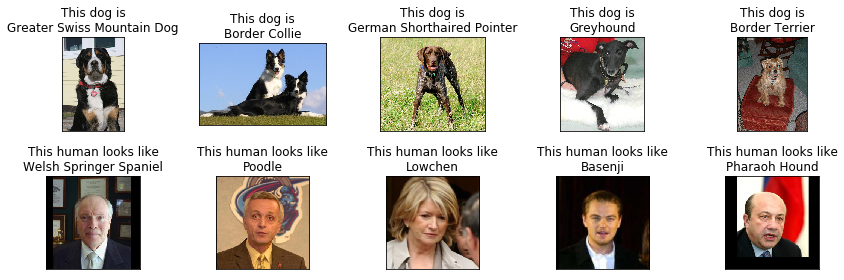

In [0]:
# Test the application

n_samples = 5

np.random.seed(0)
human_files_samples = np.random.choice(human_files, n_samples)
dog_files_samples = np.random.choice(dog_files, n_samples)

fig = plt.figure(figsize=(12, 4))

i = 0
for file in np.hstack((dog_files_samples, human_files_samples)):
  title = run_app(file, show_output=False)

  i += 1
  ax = fig.add_subplot(2, 10/2, i, xticks=[], yticks=[])
  plt.imshow(Image.open(file))
  ax.set_title(title, fontsize=12)

fig.tight_layout()